<a href="https://colab.research.google.com/github/lautitorraca/7506R-2C2023-GRUPO24/blob/main/TP1/7506R_TP1_GRUPO24_CHP3_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install 'dtreeviz'

In [63]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
    recall_score,
    f1_score,
    precision_score,
)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz.trees as dtreeviz

# Modelos y métricas
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

#Download
from google.colab import files

# Configuración de advertencias
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [12]:
# url_train = '/content/df_train_dummies.csv'
# url_test = '/content/df_test_dummies.csv'

url_train = 'https://raw.githubusercontent.com/lautitorraca/7506R-2C2023-GRUPO24/main/TP1/DataSets/hotels_train.csv'
url_test = 'https://raw.githubusercontent.com/lautitorraca/7506R-2C2023-GRUPO24/main/TP1/DataSets/df_base_limpio.csv'

ds_train_base = pd.read_csv(url_train)
ds_test_base = pd.read_csv(url_test)

ds_test = ds_test_base.copy()
df_test = pd.DataFrame(ds_test_base)

ds_train = ds_train_base.copy()
df_train = pd.DataFrame(ds_train_base)

### cosas

In [13]:
df_train['adults'].mask(df_train['adults'] > 6, df_train['adults'].median(), inplace=True)
df_train['adults'].mask(df_train['adults'] < 1, df_train['adults'].median(), inplace=True)
df_train['babies'].mask(df_train['babies'] > 3, df_train['adults'].median(), inplace=True)


In [14]:
df_train['room_type_match'] = df_train['assigned_room_type'] == df_train['reserved_room_type']
df_test['room_type_match'] = df_test['assigned_room_type'] == df_test['reserved_room_type']

df_train['days_in_waiting_list'] = df_train['days_in_waiting_list'] >= 0

df_train['cancel_to_noncancel_ratio'] = df_train['previous_cancellations'] / (1 + df_train['previous_bookings_not_canceled'])
df_test['cancel_to_noncancel_ratio'] = df_test['previous_cancellations'] / (1 + df_test['previous_bookings_not_canceled'])

df_train['lead_time_category'] = pd.cut(df_train['lead_time'], bins=[0, 10, 50, 100, 500, 10000], labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'], right=False)
df_test['lead_time_category'] = pd.cut(df_test['lead_time'], bins=[0, 10, 50, 100, 500, 10000], labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'], right=False)

df_train['days_in_waiting_list_category'] = pd.cut(df_train['days_in_waiting_list'], bins=[0, 10, 50, 100, 500, 10000], labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'], right=False)
df_test['days_in_waiting_list_category'] = pd.cut(df_test['days_in_waiting_list'], bins=[0, 10, 50, 100, 500, 10000], labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'], right=False)

df_train.dropna(subset=['children'], inplace=True)

df_train.dropna(subset=['agent'], inplace=True)

country_counts_train = df_train['country'].value_counts()
country_counts_test = df_test['country'].value_counts()

# Selecciona los 10 países más relevantes
top_10_countries_train = country_counts_train.head(10).index.tolist()
top_10_countries_test = country_counts_test.head(10).index.tolist()

# Reemplaza los países que no están en los 10 más relevantes con "otro"
df_train['country'] = df_train['country'].apply(lambda x: x if x in top_10_countries_train else 'otro')
df_test['country'] = df_test['country'].apply(lambda x: x if x in top_10_countries_test else 'otro')


market_segment_counts_train = df_train['market_segment'].value_counts()
market_segment_counts_test = df_test['market_segment'].value_counts()


top_3_ms_train = market_segment_counts_train.head(4).index.tolist()
top_3_ms_test = market_segment_counts_test.head(4).index.tolist()

df_train['market_segment'] = df_train['market_segment'].apply(lambda x: x if x in top_3_ms_train else 'otro')
df_test['market_segment'] = df_test['market_segment'].apply(lambda x: x if x in top_3_ms_test else 'otro')

ct_counts_train = df_train['customer_type'].value_counts()
ct_counts_test = df_test['customer_type'].value_counts()


top_ct_train = ct_counts_train.head(2).index.tolist()
top_ct_test = ct_counts_test.head(2).index.tolist()

df_train['customer_type'] = df_train['customer_type'].apply(lambda x: x if x in top_ct_train else 'otro')
df_test['customer_type'] = df_test['customer_type'].apply(lambda x: x if x in top_ct_test else 'otro')


columna_a_eliminar_test = 'reservation_status_date'

df_test.drop(columna_a_eliminar_test, axis='columns', inplace = True)
df_test.insert(1, 'is_canceled', " ")
df_test = pd.DataFrame(df_test)


features = ['lead_time_category','booking_changes','required_car_parking_spaces','total_of_special_requests','room_type_match','cancel_to_noncancel_ratio', 'is_repeated_guest',
             'previous_cancellations','country', 'market_segment', 'deposit_type', 'distribution_channel', 'stays_in_weekend_nights', 'adults','babies', 'days_in_waiting_list_category',
             'customer_type','hotel','is_canceled','id']


df_trabajo_train = df_train[features]
df_trabajo_test = df_test[features]


columns_to_dum= ['lead_time_category','hotel', 'country', 'market_segment', 'deposit_type', 'distribution_channel', 'days_in_waiting_list_category', 'customer_type']
df_trabajo_train_dum = pd.get_dummies(df_trabajo_train, columns = columns_to_dum)
df_trabajo_test_dum = pd.get_dummies(df_trabajo_test, columns = columns_to_dum)


### KNN

In [15]:
X = df_trabajo_train_dum.drop(['is_canceled', 'id'], axis=1)
y = df_trabajo_train_dum['is_canceled'].copy()
# df_train.dropna(inplace = True)

# X = df_train.drop(['is_canceled', 'id'], axis=1)
# y = df_train['is_canceled'].copy()



In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(19,20) # vecinos desde 1 hasta cantidad total de puntos en test

for n in k_range:

    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    metrics.append((n, (y_test == y_pred).sum()))

In [18]:

param_dist = {
             'n_neighbors':[27],
              'weights':['distance'],
              'algorithm':['kd_tree'],
              'metric':['minkowski']
}
knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, cv=10, scoring='f1', random_state=42)
random_search.fit(X_train, y_train)

print("Mejores hiperparámetros: ", random_search.best_params_)

random_search.cv_results_['mean_test_score']

print('best params: ',random_search.best_params_)

print('best score: ',random_search.best_score_)

Mejores hiperparámetros:  {'weights': 'distance', 'n_neighbors': 27, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
best params:  {'weights': 'distance', 'n_neighbors': 27, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
best score:  0.8199021062406364


Mejores hiperparámetros:  {'weights': 'distance', 'n_neighbors': 27, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
best params:  {'weights': 'distance', 'n_neighbors': 27, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
best score:  0.8200656794820416

In [19]:
best_knn=random_search.best_estimator_

y_pred = best_knn.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"F1-Score en el conjunto de prueba con las características seleccionadas: {f1:.4f}")

F1-Score en el conjunto de prueba con las características seleccionadas: 0.8151


Text(50.722222222222214, 0.5, 'True')

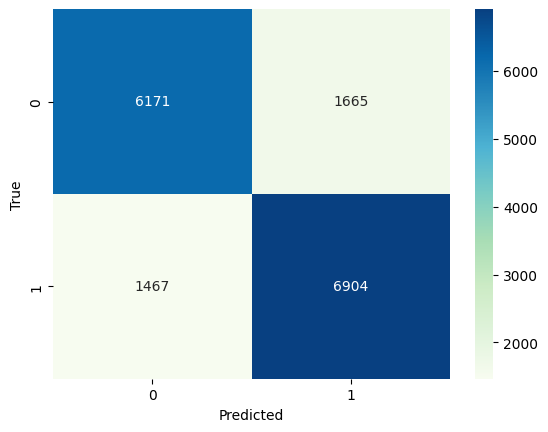

In [20]:
tabla1 = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla1,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')


In [21]:
def mostrar_metricas(y_test, y_pred):
    accuracy=accuracy_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

In [22]:
mostrar_metricas(y_test, y_pred)

Accuracy: 0.806750169679768
Recall: 0.824752120415721
Precision: 0.8056949469016221
f1 score: 0.815112160566706


In [26]:

df_knn = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
ids1 = df_trabajo_test_dum['id'].copy()

pred_knn = best_knn.predict(df_knn)

df_pred_knn = pd.DataFrame({'id': ids1, 'is_canceled': pred_knn})

df_pred_knn.to_csv('df_pred_knn.csv')
files.download('df_pred_knn.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### SVM

In [27]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [28]:

# #Armo una version escalada con minmax (media=0 , var=1  )
# min_max_scaler = preprocessing.MinMaxScaler()
# x_train_minmax = min_max_scaler.fit_transform(X_train)
# x_test_minmax  = min_max_scaler.transform(X_test)

# #Armo una version estandarizada
# stand_scaler = preprocessing.StandardScaler()
# x_train_norm = stand_scaler.fit_transform(X_train)
# x_test_norm=stand_scaler.transform(X_test)

In [29]:
# #Construyo un modelo SVM
# svm = SVC()

# #Lo entreno con los datos sin escalar
# svm.fit(X_train, y_train)

# #Hago la prediccion y calculo las métricas
# y_pred1=svm.predict(X_test)
# metricas(y_pred1,y_test)

In [30]:
# mostrar_metricas(y_test, y_pred1)

In [31]:
# #Construyo un modelo SVM
# svm_norm= SVC()

# #Lo entreno con los datos escalados con normalizacion
# svm_norm.fit(x_train_norm, y_train)

# #Hago la prediccion y calculo las métricas
# y_pred_norm1=svm_norm.predict(x_test_norm)
# metricas(y_pred_norm1,y_test)

In [32]:
# mostrar_metricas(y_test, y_pred_norm1)

SVM - Kernels

In [33]:
# #Creo un clasificador con kernel lineal y lo entreno sobre los datos escalados min-max
# clf = SVC(kernel='linear', C=5)
# clf.fit(x_train_minmax, y_train)

# #Hago la predicción y calculo las métricas
# y_pred_lin=clf.predict(x_test_minmax)
# metricas(y_pred_lin,y_test)

In [34]:
# mostrar_metricas(y_test, y_pred_lin)

SVM con kernel POLINOMICO

In [35]:
# #Creo un clasificador con kernel polinomico y lo entreno sobre los datos escalados min-max
# clf = SVC(kernel='poly', C=5, degree=10, gamma=10, coef0=10)
# clf.fit(x_train_minmax, y_train)

# #Hago la predicción y calculo las métricas
# y_pred_pol=clf.predict(x_test_minmax)
# metricas(y_pred_pol,y_test)

In [36]:
# mostrar_metricas(y_test, y_pred_pol)

**SVM con kernel RADIAL**

In [37]:
# #Creo un clasificador con kernel radial y lo entreno sobre los datos escalados min-max
# clf = SVC(kernel='rbf', C=5, gamma=10)
# clf.fit(x_train_minmax, y_train)

# #Hago la predicción y calculo las métricas
# y_pred_rad=clf.predict(x_test_minmax)
# metricas(y_pred_rad,y_test)

In [38]:
# mostrar_metricas(y_test, y_pred_rad)

### ENSAMBLES

### RF - KFOLD CROSSVALIDATION

In [39]:
rfc = RandomForestClassifier(max_features='auto',
                             oob_score=True,
                             random_state=2,
                             n_jobs=-1,
                             criterion="entropy",
                             min_samples_leaf=5,
                             min_samples_split=5,
                             n_estimators=50 )
#Entrenamos el modelo
model = rfc.fit(X = X_train, y = y_train)

In [40]:
y_predRF = model.predict(X_test)

Text(50.722222222222214, 0.5, 'True')

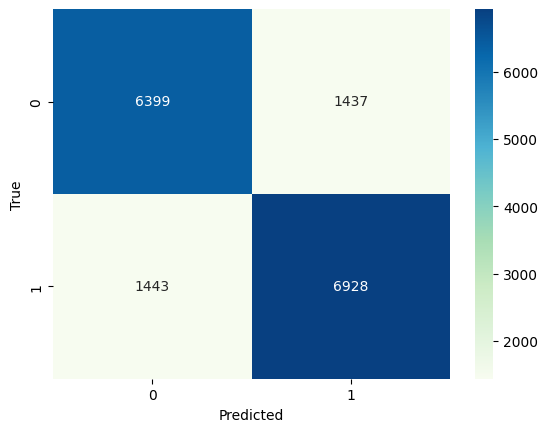

In [41]:
tabla=confusion_matrix(y_test, y_predRF)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [42]:
mostrar_metricas(y_test,y_predRF)

Accuracy: 0.8222990066020855
Recall: 0.8276191613905148
Precision: 0.8282127913927078
f1 score: 0.8279158699808795


In [43]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 5, 10],
               "min_samples_split" : [2, 4, 10, 12, 16],
               "n_estimators": [10,20, 50] }

gs = RandomizedSearchCV(estimator=rf_cv, param_distributions=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs_fit = gs.fit(X = X_train, y = y_train)

In [44]:
gs_fit.best_params_

{'n_estimators': 20,
 'min_samples_split': 16,
 'min_samples_leaf': 1,
 'criterion': 'gini'}

In [45]:
print("F1 en entrenamiento con cv: "+str(gs_fit.best_score_))

F1 en entrenamiento con cv: 0.8318180339007192


In [46]:
rf_cv_best=gs_fit.best_estimator_

y_pred_rf_cv_best = rf_cv_best.predict(X_test)

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      7836
           1       0.83      0.82      0.83      8371

    accuracy                           0.82     16207
   macro avg       0.82      0.82      0.82     16207
weighted avg       0.82      0.82      0.82     16207



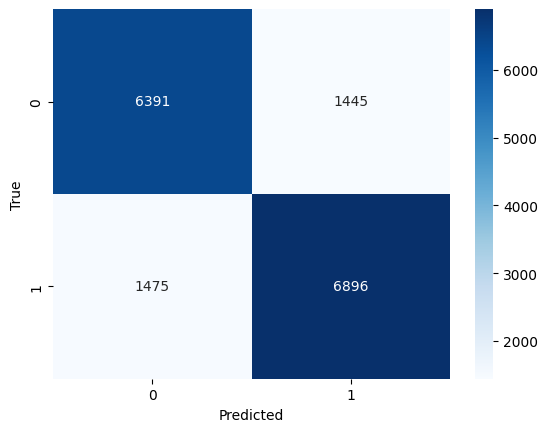

In [47]:
tabla=confusion_matrix(y_test,y_pred_rf_cv_best)

sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_pred_rf_cv_best))

In [48]:
mostrar_metricas(y_test,y_pred_rf_cv_best)

Accuracy: 0.8198309372493368
Recall: 0.8237964400907897
Precision: 0.8267593813691404
f1 score: 0.8252752513164193


In [49]:

df_rf = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
ids2 = df_trabajo_test_dum['id'].copy()

pred_rf = rf_cv_best.predict(df_knn)

df_pred_rf = pd.DataFrame({'id': ids2, 'is_canceled': pred_rf})

df_pred_rf.to_csv('df_pred_rf.csv')
files.download('df_pred_rf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### XGBOOST

In [50]:

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2]
}

xgb_model = XGBClassifier()

n_iter_search = 40

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=n_iter_search, scoring='f1', cv=3, verbose=1)
random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [51]:

best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

AUC: 0.9190555625784318
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      7836
           1       0.82      0.84      0.83      8371

    accuracy                           0.82     16207
   macro avg       0.82      0.82      0.82     16207
weighted avg       0.82      0.82      0.82     16207



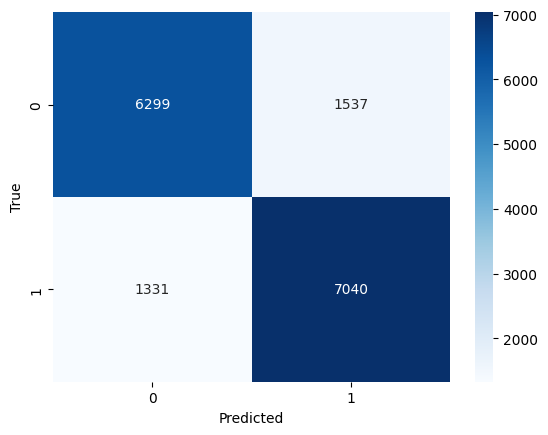

In [52]:

y_pred_proba= best_xgb.predict_proba(X_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

y_predxgboost=best_xgb.predict(X_test)

cm = confusion_matrix(y_test,y_predxgboost)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(classification_report(y_test,y_predxgboost))


In [53]:
mostrar_metricas(y_test,y_predxgboost)

Accuracy: 0.8230394274079101
Recall: 0.8409986859395532
Precision: 0.8207998134545879
f1 score: 0.8307764928015104


In [54]:
data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.1},num_boost_round=8,metrics='auc')
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.884247,0.000348,0.883063,0.002160
1,0.887290,0.000413,0.886082,0.001788
2,0.889518,0.000372,0.888266,0.001891
3,0.892823,0.000210,0.892028,0.001369
4,0.891206,0.000220,0.890394,0.001561
5,0.893444,0.002210,0.892755,0.002344
6,0.898352,0.000779,0.897584,0.001344
7,0.901153,0.001027,0.900124,0.001962


In [55]:
results=xgb.cv(dtrain=data_dmatrix,nfold=5,params={'learning_rate':0.2},num_boost_round=8,metrics='auc',seed=0)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.884247,0.000348,0.883063,0.002160
1,0.889591,0.001215,0.888345,0.002253
2,0.891319,0.001411,0.890286,0.002752
3,0.898836,0.001158,0.897982,0.001974
4,0.902440,0.000727,0.901317,0.001427
5,0.903898,0.001510,0.902786,0.001526
6,0.906099,0.000861,0.904840,0.001959
7,0.908641,0.001287,0.906875,0.002594


In [56]:
from google.colab import files
df_xgb = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
ids3 = df_trabajo_test_dum['id'].copy()

pred_xgb = best_xgb.predict(df_xgb)

df_pred_xgb = pd.DataFrame({'id': ids3, 'is_canceled': pred_xgb})

df_pred_xgb.to_csv('df_pred_xgb.csv')
files.download('df_pred_xgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ensamble STACKING

In [57]:
#Creo un conjunto de datos para entrenar los modelos
x, y = make_classification(n_samples=3000,
                           n_features=20,
                           n_informative=15,
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=2)

In [58]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [59]:
#Funcion para plotear a performance
def plot_results(model_scores, name):

    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )

    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [64]:
#Modelos Base
base_models = {'random_forest':RandomForestClassifier(n_estimators=50),
               'svm': SVC(),
               'knn': KNeighborsClassifier(n_neighbors=11)}

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, X_train, y_train)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   15.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating svm


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  7.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating knn


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   22.1s finished


In [65]:
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier(n_neighbors=11))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models,
                                    final_estimator=meta_model,
                                    passthrough=True,
                                    cv=5,
                                    verbose=2)

In [66]:
#Performance el modelo en entrenamiento
stacking_scores = evaluate_model(stacking_model, X_train, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 34.7min finished


In [69]:
#Evaluo en conjunto de test

stacking_model.fit(X_train,y_train)
y_pred_st = stacking_model.predict(X_test)
accuracy_score(y_test, y_pred_st)

0.8235947430122786

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      7836
           1       0.83      0.83      0.83      8371

    accuracy                           0.82     16207
   macro avg       0.82      0.82      0.82     16207
weighted avg       0.82      0.82      0.82     16207



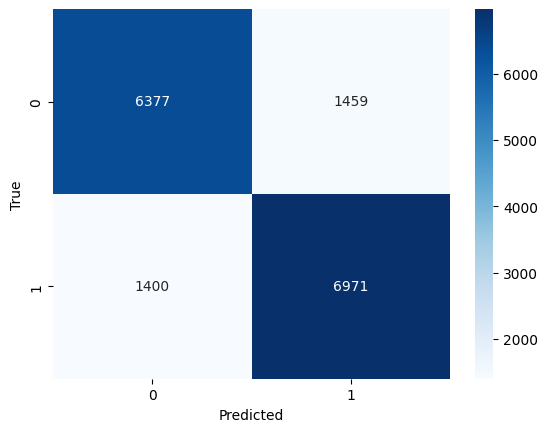

In [70]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_st)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_st))

In [71]:
mostrar_metricas(y_test,y_pred_st)

Accuracy: 0.8235947430122786
Recall: 0.8327559431370206
Precision: 0.8269276393831554
f1 score: 0.8298315576453782


In [72]:
df_stacking = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
ids4 = df_trabajo_test_dum['id'].copy()

pred_stacking = stacking_model.predict(df_stacking)

df_pred_stacking = pd.DataFrame({'id': ids4, 'is_canceled': pred_stacking})

df_pred_stacking.to_csv('df_pred_stacking.csv')
files.download('df_pred_stacking.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#VOTING

In [73]:
#Creo un conjunto de datos para entrenar los modelos

x, y = make_classification(n_samples=3000,
                           n_features=20,
                           n_informative=15,
                           n_redundant=5,
                           n_clusters_per_class=5,
                           class_sep=0.7,
                           flip_y=0.03,
                           n_classes=2)

In [74]:
#Creo clasificadores

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.80)

#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
y_pred_voting = vot_clf.predict(x_test)
accuracy_score(y_test, y_pred_voting)

0.82

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       289
           1       0.86      0.77      0.82       311

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



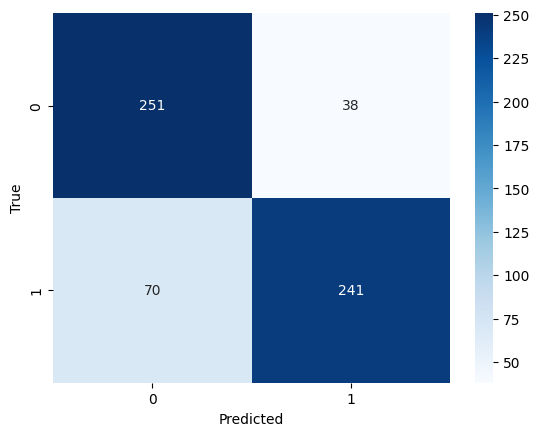

In [75]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_voting)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_voting))

In [76]:
mostrar_metricas(y_test,y_pred_voting)

Accuracy: 0.82
Recall: 0.77491961414791
Precision: 0.8637992831541219
f1 score: 0.816949152542373


In [77]:

# df_voting = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
# ids5 = df_trabajo_test_dum['id'].copy()

# pred_voting = vot_clf.predict(df_voting)

# df_pred_voting = pd.DataFrame({'id': ids5, 'is_canceled': pred_voting})

# df_pred_voting.to_csv('df_pred_voting.csv')
# files.download('df_pred_voting.csv')


ValueError: ignored